In [2]:
import random

# BMIを計算して体型を返す
def calc_bmi(h,w):
    bmi = w / (h/100)**2
    if bmi < 18.5: return 'thin'
    if bmi < 25: return 'normal'
    return 'fat'

# 出力ファイルの準備
fp = open('./data/bmi/bmi.csv', 'w', encoding='utf-8')
fp.write('height,weight,label\r\n')

# ランダムなデータを生成
cnt = {'thin':0, 'normal':0, 'fat':0}
for i in range(20000):
    h = random.randint(120,200) # 身長120cm - 200cm
    w = random.randint(35, 80) # 体重35 - 80
    label = calc_bmi(h, w)
    cnt[label] += 1
    fp.write('{0},{1},{2}\r\n'.format(h,w,label))
fp.close()
print('ok,', cnt)

ok, {'thin': 6381, 'normal': 5953, 'fat': 7666}


In [13]:
# bmiを予測
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# データの読み込み
tbl = pd.read_csv('./data/bmi/bmi.csv')

tbl.head()
# カラムをスライス(分割)して正規化
label = tbl['label']
h = tbl['height'] / 200 # 最大値200cmで正規化
w = tbl['weight'] / 100 # 最大100kgで正規化
wh = pd.concat([w,h], axis=1)

# 学習用とテスト用データに分ける
data_train, data_test, label_train, label_test = \
    train_test_split(wh, label)

# データを学習
clf = svm.SVC()
clf.fit(data_train, label_train)

# データを予測
predict = clf.predict(data_test)

# あっているか確認
ac_score = metrics.accuracy_score(label_test,predict)
cl_report = metrics.classification_report(label_test, predict)
print('正解率：', ac_score)
print('レポート：\n', cl_report)




正解率： 0.9964
レポート：
               precision    recall  f1-score   support

         fat       1.00      1.00      1.00      1967
      normal       0.99      1.00      0.99      1463
        thin       1.00      0.99      1.00      1570

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



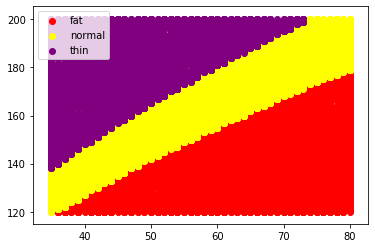

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# PandasでCSVファイルを読み
tbl = pd.read_csv('./data/bmi/bmi.csv', index_col=2)

# 描画を開始する
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# サブプロット用 - 指定のラベルを任意の色で描画
def scatter(lbl, color):
    b = tbl.loc[lbl]
    ax.scatter(b['weight'],b['height'], c=color, label=lbl)

scatter('fat', 'red')
scatter('normal', 'yellow')
scatter('thin', 'purple')

ax.legend() # 凡例表示
plt.savefig('bmi-test.png')
plt.show()

In [2]:
import requests

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
res = requests.get(url)

with open('./data/mushroom/mushroom.csv', 'w', encoding='utf-8') as fp:
    fp.write(res.text)
fp.close()

### Mashroomのデータについて
- 1行が1種類のキノコ
- 1列目(左端):ラベル - p(poisonous):毒, e(edible):食用
- 2列目:キノコの形 - b:ベル型, c:円錐型, x:凸型, f:平たい, k:こぶ型, 凹型:s
- 4列目:キノコの色 - n:茶, b:黄褐, c:肉桂, g:灰色, r:緑, p:ピンク, u:紫, e:赤, w:白, y:黄色

### ポイント
- 上記特徴をどう数値に変換するかが問題になる。(特徴変換)
- 記号が一文字であることに注目して、文字コードに変換して値としてみる。unicoding point

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

# データの読み込み
df = pd.read_csv('./data/mushroom/mushroom.csv', header=None)

# データ中の記号を数値に変換する
label = []
data = []
attr_list = []
for row_index, row in df.iterrows(): # 一行ずつ取り出す
    label.append(row.loc[0])
    row_data = []
    for v in row.loc[1:]:
        row_data.append(ord(v))
    data.append(row_data)

# 学習用とテスト用データに分ける
data_train, data_test, label_train, label_test =\
    train_test_split(data, label)

# データの学習
clf = RandomForestClassifier()
clf.fit(data_train, label_train)

# データを予測
predict = clf.predict(data_test)

# 正解率の確認
ac_score = metrics.accuracy_score(label_test, predict)
cl_report = metrics.classification_report(label_test, predict)
print('正解率:', ac_score)
print('レポート:\n', cl_report)



正解率: 1.0
レポート:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00      1045
           p       1.00      1.00      1.00       986

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# データの読み込み
df = pd.read_csv('./data/mushroom/mushroom.csv', header=None)

# データ中の分類変数を展開する
label = []
data = []
attr_list = []
for row_index, row in df.iterrows():
    label.append(row.loc[0])
    exdata = []
    for col, v in enumerate(row.loc[1:]):
        if row_index == 0:
            attr = {'dic':{}, 'cnt':0}
            attr_list.append(attr)
        else:
            attr = attr_list[col]
        # キノコの特徴を表す記号を12列
        d = [0,0,0,0,0,0,0,0,0,0,0,0]
        if v in attr['dic']:
            idx = attr['dic'][v]
        else:
            idx = attr['cnt']
            attr['dic'][v] = idx
            attr['cnt'] += 1
        d[idx] = 1
        exdata += d
    data.append(exdata)

# 学習用とテスト用データに分ける
data_train, data_test, label_train, label_test =\
    train_test_split(data, label)
# 学習
clf = RandomForestClassifier()
clf.fit(data_train, label_train)
# データを予測
predict = clf.predict(data_test)

# 正解率
ac_score = metrics.accuracy_score(label_test, predict)
print('正解率：', ac_score)

正解率： 1.0


In [32]:
from sklearn import svm, metrics
from sklearn import datasets
from sklearn import model_selection
import random, re
import pandas as pd

# Irisデータ読み込み
iris = datasets.load_iris()
data = pd.DataFrame(iris.data)
label = pd.DataFrame(iris.target)

clf = svm.SVC()
scores = model_selection.cross_val_score(clf, data, label, cv=5)
print('各正答率', scores)
print('正解率:', scores.mean())

各正答率 [0.96666667 0.96666667 0.96666667 0.93333333 1.        ]
正解率: 0.9666666666666666


In [40]:
import pandas as pd
from sklearn import model_selection, svm, metrics

# MNISTデータを読み込む
train_csv = pd.read_csv('./data/mnist/train.csv')
test_csv = pd.read_csv('./data/mnist/t10k.csv')

# 必要な列を抽出
train_label = train_csv.iloc[:,0]
train_data = train_csv.iloc[:, 1:577]
test_label = test_csv.iloc[:, 0]
test_data = test_csv.iloc[:,1:577]
print('学習データ数:', len(train_label))

# グリッドサーチのパラメータ設定
params =[
    {'C': [1,10,100,1000], 'kernel':['linear']},
    {'C':[1,10,100,1000], 'kernel':['rbf'], 'gamma':[0.001,0.0001]}
]

# グリッドサーチ
clf = model_selection.GridSearchCV(svm.SVC(), params, n_jobs=-1)
clf.fit(train_data, train_label)
print('学習器=', clf.best_estimator_)

# テストデータを確認
pre = clf.predict(test_data)
ac_score = metrics.accuracy_score(pre, test_label)
print('正解率：', ac_score)


学習データ数: 1000
学習器= SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
正解率： 0.866
